In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path='/content/drive/MyDrive/Tomato'

In [3]:
import tensorflow as tf
from tensorflow.keras import models,KerasTensor
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=32,

)

Found 1556 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names

In [6]:
print(class_names)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


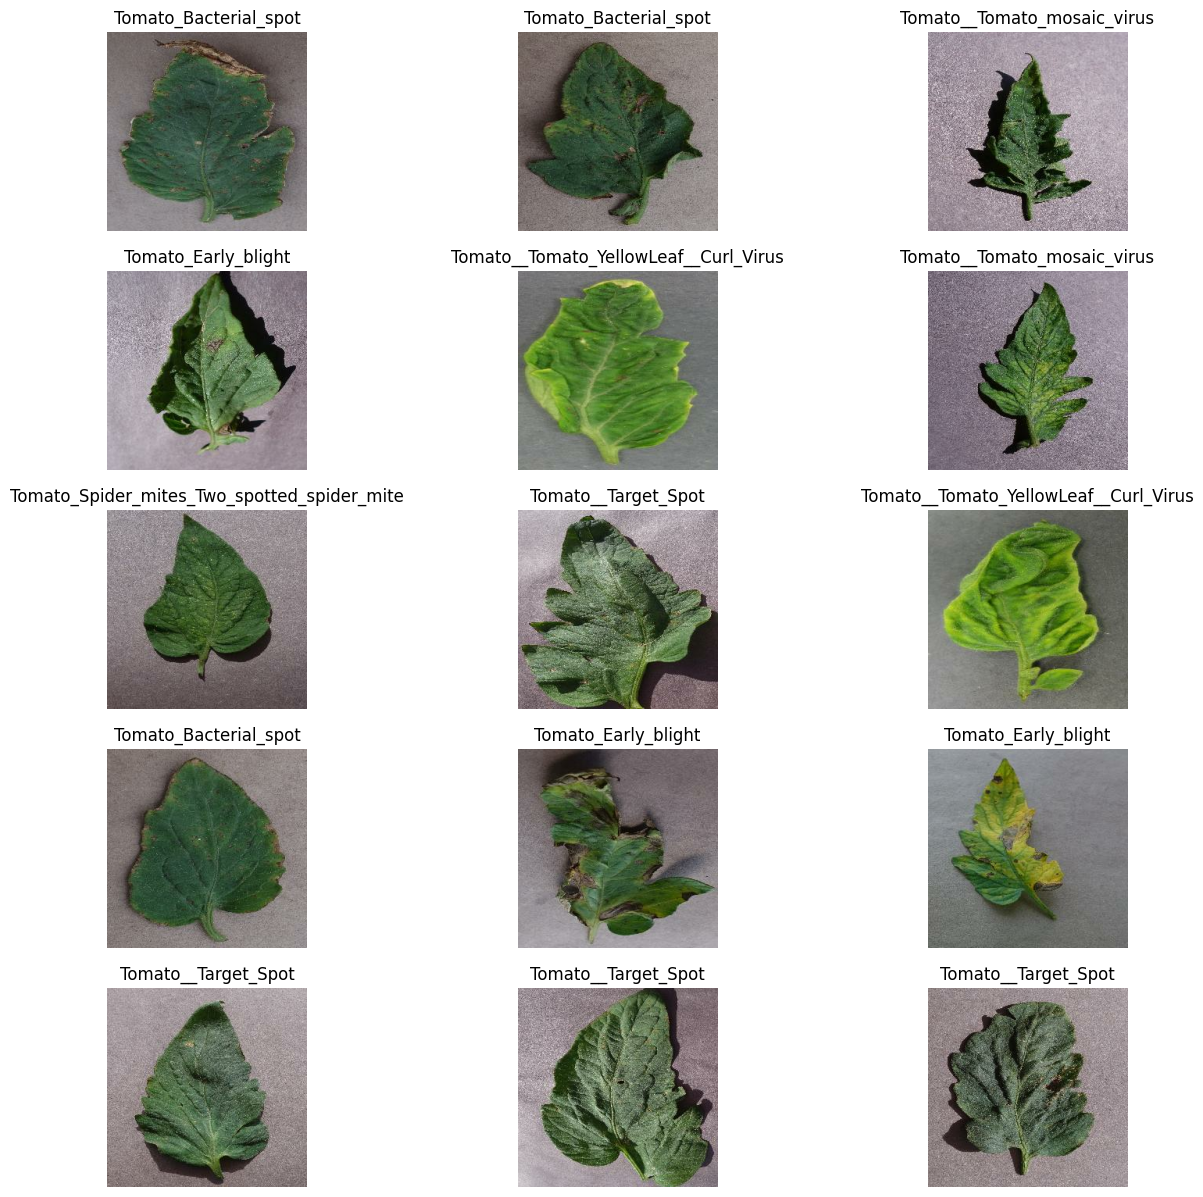

In [7]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(5,3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
print(len(test_ds))

6


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(256,256),
  tf.keras.layers.Rescaling(1./255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),

])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
input_shape = (32, 256,256,3)

model = models.Sequential([
    resize_and_rescale,


    layers.Conv2D(32,kernel_size = (3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,kernel_size = (3,3),activation='relu',),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])
model.build(input_shape=input_shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 12544)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,778 (3.42 MB)

 Trainable params: 896,778 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

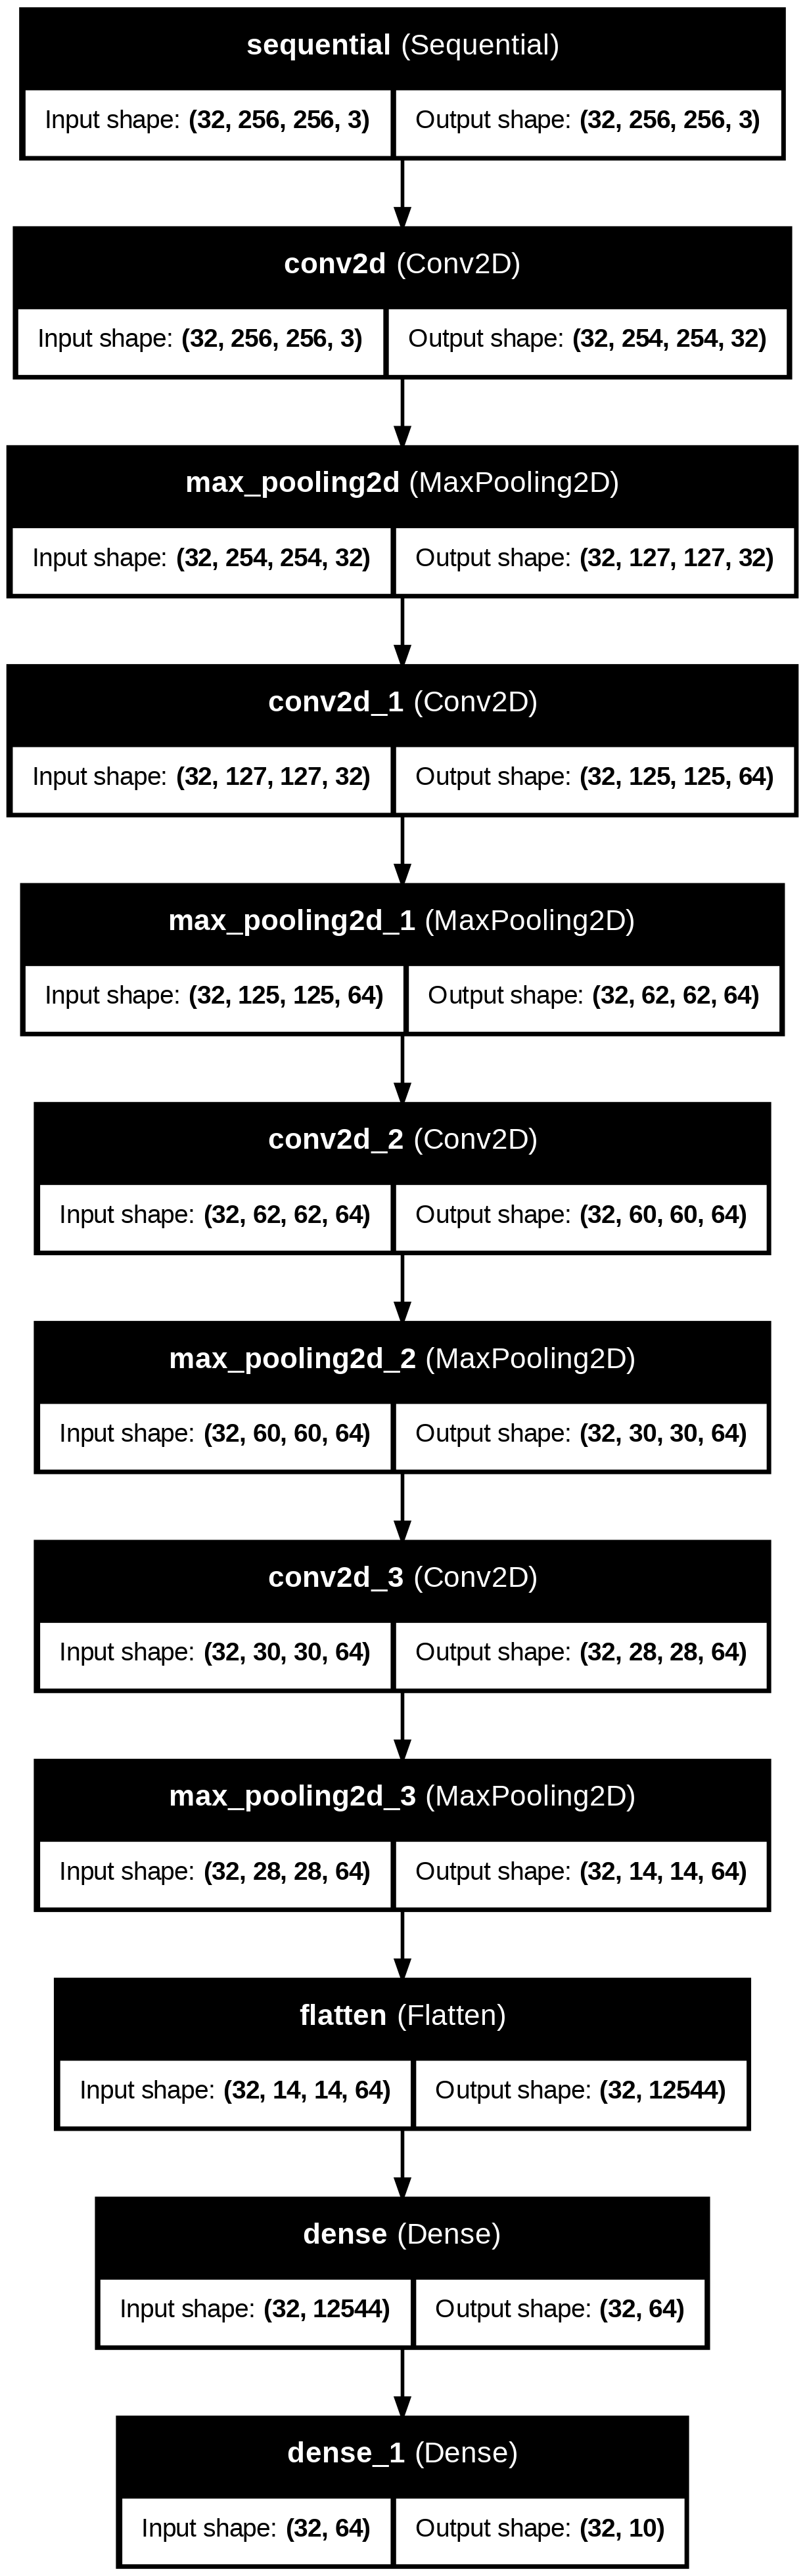

In [17]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    verbose=1,
    epochs=100,
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 480s 770ms/step - accuracy: 0.1237 - loss: 2.2964 - val_accuracy: 0.2266 - val_loss: 2.2582
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 373ms/step - accuracy: 0.2121 - loss: 2.2326 - val_accuracy: 0.2344 - val_loss: 2.0604
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3027 - loss: 1.9783 - val_accuracy: 0.3906 - val_loss: 1.9244
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - accuracy: 0.4033 - loss: 1.7524 - val_accuracy: 0.2969 - val_loss: 2.1212
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 371ms/step - accuracy: 0.4425 - loss: 1.6591 - val_accuracy: 0.3906 - val_loss: 1.9011
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.4673 - loss: 1.5038 - val_accuracy: 0.5234 - val_loss: 1.5284
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 373ms/step - accuracy: 0.5590 - loss: 1.2824 - val_accuracy: 0.6094 - val_loss: 1.4435
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - accuracy: 0.5802 - loss: 1.2636 -

In [20]:
from tensorflow.keras.models import load_model
model.save('model.h5')

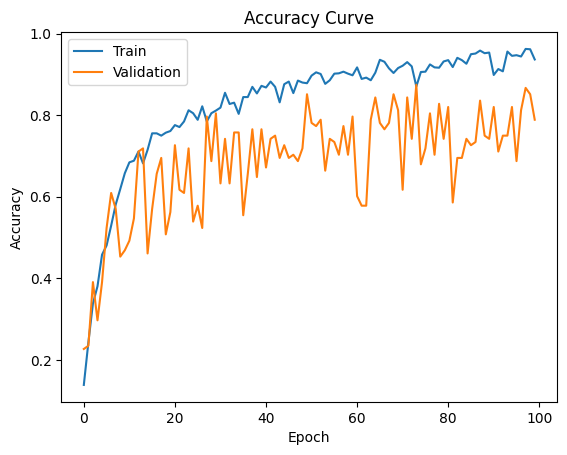

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

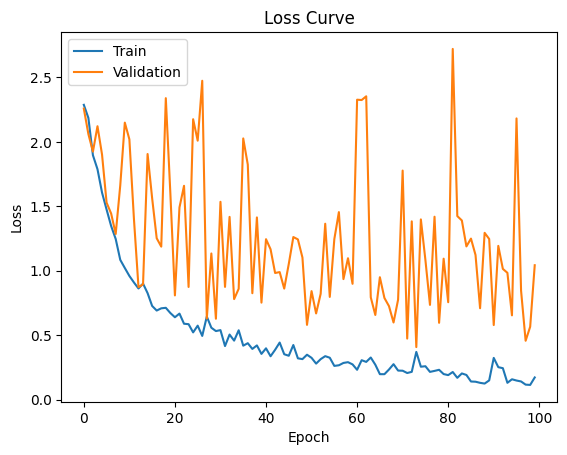

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
history.history['loss'][:]

[2.287358522415161,
 2.1856863498687744,
 1.8959537744522095,
 1.7877987623214722,
 1.6058751344680786,
 1.474547028541565,
 1.346722960472107,
 1.2462308406829834,
 1.084399938583374,
 1.0212035179138184,
 0.9596002697944641,
 0.9090072512626648,
 0.8621991872787476,
 0.9002376198768616,
 0.8260366916656494,
 0.726651668548584,
 0.6909779906272888,
 0.7082725167274475,
 0.7121546268463135,
 0.6716591119766235,
 0.6389355659484863,
 0.6673384308815002,
 0.5886114239692688,
 0.5851388573646545,
 0.5214264988899231,
 0.5737404823303223,
 0.4940375089645386,
 0.6440949440002441,
 0.5577293634414673,
 0.5316473245620728,
 0.5390684008598328,
 0.41537511348724365,
 0.504653811454773,
 0.4575127065181732,
 0.5378298759460449,
 0.4182997941970825,
 0.43767619132995605,
 0.3931262195110321,
 0.42034071683883667,
 0.35463735461235046,
 0.3977762758731842,
 0.3363155722618103,
 0.38649168610572815,
 0.4426123797893524,
 0.35188788175582886,
 0.34013426303863525,
 0.42342931032180786,
 0.32016399

In [24]:
history.history['accuracy'][:]

[0.1383495181798935,
 0.24271844327449799,
 0.33818769454956055,
 0.3802588880062103,
 0.4579288065433502,
 0.4805825352668762,
 0.5291262269020081,
 0.5809061527252197,
 0.6189320683479309,
 0.6577669978141785,
 0.6844660043716431,
 0.688511312007904,
 0.7111650705337524,
 0.6820388436317444,
 0.7152103781700134,
 0.7556634545326233,
 0.7556634545326233,
 0.75,
 0.7572815418243408,
 0.7613268494606018,
 0.7758899927139282,
 0.7710356116294861,
 0.7847896218299866,
 0.8122977614402771,
 0.8050161600112915,
 0.7888349294662476,
 0.8220064640045166,
 0.7847896218299866,
 0.8050161600112915,
 0.811488687992096,
 0.8187702298164368,
 0.8551779985427856,
 0.8276699185371399,
 0.8309061527252197,
 0.803398072719574,
 0.844660222530365,
 0.844660222530365,
 0.8697410821914673,
 0.8535598516464233,
 0.8721683025360107,
 0.8681229948997498,
 0.8826860785484314,
 0.8697410821914673,
 0.8317152261734009,
 0.8762136101722717,
 0.8826860785484314,
 0.8543689250946045,
 0.8851132392883301,
 0.880258

In [25]:
history.history['val_loss'][:]

[2.2581675052642822,
 2.0604333877563477,
 1.9243857860565186,
 2.121208667755127,
 1.9010868072509766,
 1.5284031629562378,
 1.4435179233551025,
 1.2851736545562744,
 1.662719488143921,
 2.1493754386901855,
 2.0199108123779297,
 1.4038066864013672,
 0.8729091286659241,
 0.8937005996704102,
 1.9057092666625977,
 1.562612771987915,
 1.2520171403884888,
 1.1869652271270752,
 2.339049816131592,
 1.5999329090118408,
 0.8083869218826294,
 1.491403579711914,
 1.6588938236236572,
 0.87400883436203,
 2.175611972808838,
 2.00933837890625,
 2.474113941192627,
 0.6289669275283813,
 1.133824110031128,
 0.6273519396781921,
 1.5348012447357178,
 0.8745222687721252,
 1.4179103374481201,
 0.7798986434936523,
 0.8597850799560547,
 2.0265283584594727,
 1.8234624862670898,
 0.8254181146621704,
 1.4136145114898682,
 0.7523596286773682,
 1.2447760105133057,
 1.166599988937378,
 0.9823153614997864,
 0.9894497394561768,
 0.8612303733825684,
 1.0528590679168701,
 1.2613131999969482,
 1.2432372570037842,
 1.10

In [26]:
history.history['val_accuracy'][:]

[0.2265625,
 0.234375,
 0.390625,
 0.296875,
 0.390625,
 0.5234375,
 0.609375,
 0.5703125,
 0.453125,
 0.46875,
 0.4921875,
 0.546875,
 0.7109375,
 0.71875,
 0.4609375,
 0.5703125,
 0.65625,
 0.6953125,
 0.5078125,
 0.5625,
 0.7265625,
 0.6171875,
 0.609375,
 0.71875,
 0.5390625,
 0.578125,
 0.5234375,
 0.796875,
 0.6875,
 0.8046875,
 0.6328125,
 0.7421875,
 0.6328125,
 0.7578125,
 0.7578125,
 0.5546875,
 0.65625,
 0.765625,
 0.6484375,
 0.765625,
 0.671875,
 0.7421875,
 0.75,
 0.6953125,
 0.7265625,
 0.6953125,
 0.703125,
 0.6875,
 0.71875,
 0.8515625,
 0.78125,
 0.7734375,
 0.7890625,
 0.6640625,
 0.7421875,
 0.734375,
 0.703125,
 0.7734375,
 0.703125,
 0.796875,
 0.6015625,
 0.578125,
 0.578125,
 0.7890625,
 0.84375,
 0.78125,
 0.765625,
 0.78125,
 0.8515625,
 0.8125,
 0.6171875,
 0.84375,
 0.7421875,
 0.875,
 0.6796875,
 0.71875,
 0.8046875,
 0.703125,
 0.828125,
 0.7421875,
 0.8203125,
 0.5859375,
 0.6953125,
 0.6953125,
 0.7421875,
 0.7265625,
 0.734375,
 0.8359375,
 0.75,
 0.742

first image to predict
actual label: Tomato__Target_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
predicted label: Tomato_healthy
Time taken for prediction: 0.3556 seconds


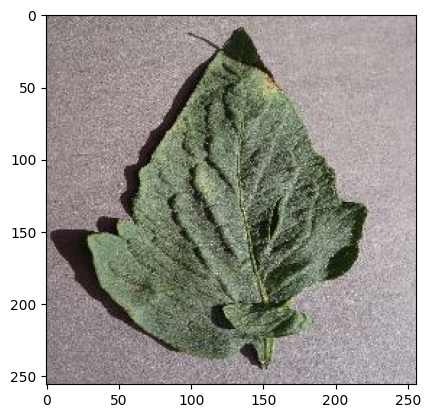

In [33]:
import numpy as np
import time
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    start_time = time.time()
    batch_prediction = model.predict(images_batch)
    end_time = time.time()
    prediction_time = end_time - start_time
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    print(f"Time taken for prediction: {prediction_time:.4f} seconds")

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [68]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

for image_batch, label_batch in test_ds:
   y_true.append(label_batch)
   #y_true.append(np.argmax(y_true, axis = 0))
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [70]:
true_labels

<tf.Tensor: shape=(192,), dtype=int32, numpy=
array([7, 6, 4, 0, 9, 6, 6, 6, 8, 7, 0, 6, 9, 9, 9, 8, 8, 4, 6, 4, 6, 0,
       9, 9, 3, 2, 0, 3, 9, 9, 2, 6, 6, 7, 0, 3, 3, 8, 2, 0, 4, 8, 6, 6,
       1, 6, 4, 0, 0, 2, 8, 7, 7, 0, 8, 6, 0, 8, 6, 0, 6, 4, 5, 4, 6, 3,
       2, 2, 2, 3, 3, 0, 3, 6, 6, 4, 8, 8, 0, 9, 6, 8, 9, 1, 9, 0, 3, 7,
       6, 9, 7, 9, 4, 9, 3, 9, 1, 6, 2, 7, 3, 9, 0, 8, 4, 9, 2, 2, 7, 6,
       7, 8, 8, 6, 0, 6, 2, 4, 3, 6, 6, 8, 4, 1, 8, 1, 9, 0, 2, 8, 1, 9,
       8, 1, 1, 8, 1, 1, 0, 9, 7, 3, 5, 6, 9, 0, 3, 4, 2, 7, 1, 2, 6, 8,
       1, 6, 3, 8, 7, 8, 1, 2, 3, 8, 6, 9, 2, 5, 7, 7, 8, 0, 0, 9, 6, 8,
       9, 6, 9, 4, 9, 9, 6, 0, 0, 5, 9, 8, 9, 7, 1, 8], dtype=int32)>

In [71]:
predicted_labels

<tf.Tensor: shape=(192,), dtype=int64, numpy=
array([7, 5, 4, 1, 9, 6, 1, 9, 9, 2, 0, 6, 9, 9, 9, 8, 8, 5, 4, 4, 6, 0,
       9, 9, 3, 3, 6, 3, 9, 9, 2, 6, 9, 7, 6, 4, 3, 8, 2, 0, 4, 8, 5, 6,
       1, 6, 4, 6, 3, 2, 9, 7, 5, 0, 8, 9, 0, 4, 9, 0, 6, 0, 5, 1, 9, 4,
       2, 2, 2, 3, 3, 0, 3, 6, 6, 1, 9, 4, 0, 9, 6, 8, 9, 5, 9, 0, 3, 1,
       1, 9, 7, 9, 4, 9, 3, 9, 1, 6, 2, 7, 3, 9, 2, 8, 4, 9, 2, 2, 8, 6,
       7, 8, 8, 9, 0, 9, 9, 1, 4, 1, 9, 9, 4, 1, 8, 1, 9, 0, 2, 8, 1, 9,
       8, 1, 1, 8, 1, 1, 0, 9, 7, 3, 5, 9, 9, 0, 4, 1, 2, 7, 1, 2, 6, 8,
       4, 5, 8, 8, 7, 8, 1, 2, 4, 8, 6, 9, 2, 5, 7, 7, 8, 1, 1, 9, 6, 8,
       9, 9, 9, 4, 9, 9, 6, 0, 1, 5, 9, 9, 9, 5, 1, 8])>

In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predicted_labels, true_labels)

In [73]:
cm

array([[14,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 4, 12,  0,  0,  4,  0,  3,  1,  0,  0],
       [ 1,  0, 14,  0,  0,  0,  0,  1,  0,  0],
       [ 1,  0,  1, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  5,  8,  0,  1,  0,  2,  0],
       [ 0,  1,  0,  0,  1,  4,  3,  2,  0,  0],
       [ 3,  0,  0,  0,  0,  0, 16,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  1, 20,  0],
       [ 0,  0,  1,  0,  0,  0, 10,  0,  5, 29]])

Text(95.72222222222221, 0.5, 'Truth')

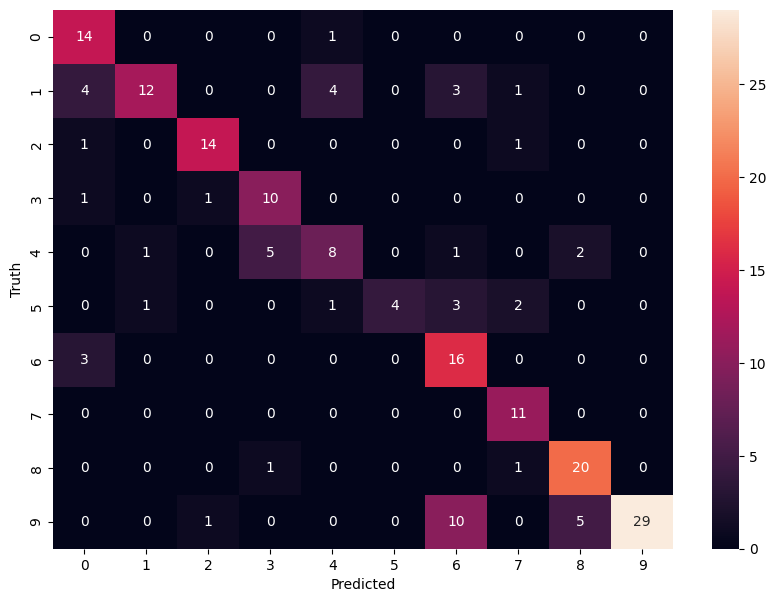

In [74]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [75]:
from sklearn.metrics import classification_report
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74        23
           1       0.50      0.86      0.63        14
           2       0.88      0.88      0.88        16
           3       0.83      0.62      0.71        16
           4       0.47      0.57      0.52        14
           5       0.36      1.00      0.53         4
           6       0.84      0.48      0.62        33
           7       1.00      0.69      0.81        16
           8       0.91      0.74      0.82        27
           9       0.64      1.00      0.78        29

    accuracy                           0.72       192
   macro avg       0.74      0.75      0.70       192
weighted avg       0.79      0.72      0.72       192

